# Mutual Fund Analysis

## Motivation

The motivation for this project is to compare various stock prices to the S&P 500.  The goal of this project is making informed investment decisions in mutual funds. This analysis will provide valuable insights in how much each fund went up or down within the past 10 years.

## About the Data

The data used in this is from yahoo finance using the yahooquery api to acess the data. For this research, the the history feature will be used highlighting the closing data of each mutual fund on the first available day of each year (generally 1/1/20xx although some years it is a few days after because insufficient data. 

In [1]:
import sys
#!{sys.executable} -m pip install yahooquery

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from yahooquery import Ticker

## Demonstration with the S&P 500

This simple visualization highlights the steady growth of the S&P 500 over the last 10 years with a few noticeable dips, particularly in 2020 as well as another recently and demonstrated what yahooquery can be used for.

Text(0.5, 1.0, 'S&P 500 Growth Over Past 10 Years')

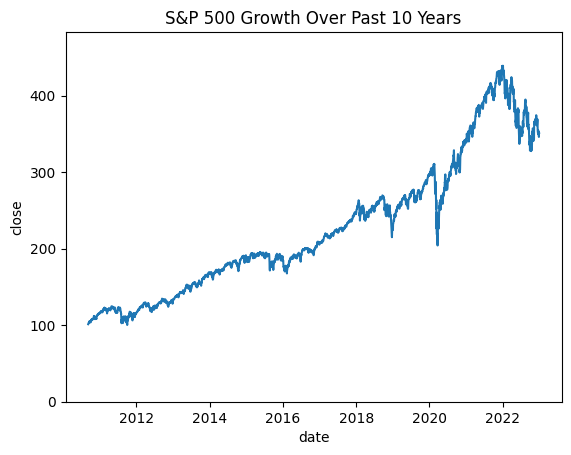

In [2]:
s_and_p_ticker = Ticker('voo').history(start='2000-01-01', end='2023-01-01')
sns.lineplot(data=s_and_p_ticker, x="date", y="close")
plt.ylim(0, max(s_and_p_ticker.loc[:,"close"]) * 1.1)
plt.title("S&P 500 Growth Over Past 10 Years")

In [3]:
# Requires the yahoo finance ticker for the stock you want
# As well as the years you want data for
# Note must be valid years where yahoo finance collected data and may not return data for current year

# Returns a multidimensional array from start_year to end_year
# The first number is the year of the value
# The second number is the price of the stock on the first available day of the year
    # NOTE: This will often be 1/1 but some years with some stocks, it does not have the data for it 
    # And it will instead get 1/2, ... to whatever the first avaliable day is
# The last value returned is the % change from last year
    # Example: if the value was 100 in 2011, 150 in 2012 and 30 in 2013, it would return for 2012 and 2013 .5, -.8 
    
# NOTE: Yahoo finance only lets the minimum year be 2012 so 2013 is the earliest you can view

def get_stock_array(ticker, start_year, end_year):
    
    # Gets the previous year for reference in % change
    # And the next year at the end to make sure it includes instead of goes up to
    start_year = start_year - 2
    
    # Sets the minimum that yahoo finance allows
    if start_year < 2012:
        start_year = 2012
    end_year = end_year + 1
    
    # Gets the ticker value
    ticker = Ticker(ticker).history(start=f'{str(start_year)}-01-01', end=f'{str(end_year)}-01-01')

    # Will be in the format [[year, price, % change from last year]...]
    year_list = list(range(start_year,end_year))

    # Takes the ticker data and inputs the year and the current price into the array 
    i = 0
    for index, row in ticker[["close"]].iterrows():
        if int(str(index[1])[0:4]) == year_list[i]:
            year_list[i]= [year_list[i], row["close"], 0]
            if len(year_list) > i + 1:
                i = i + 1

    # Adds the price change from last year to the array
    for i in range(1, len(year_list)):
        try:
            year_list[i][2] = (year_list[i][1] - year_list[i-1][1]) / year_list[i-1][1]
        except:
            return False

    # Need to remove first since first is just reference for % change
    year_list = year_list[1:]
    return year_list

In [4]:
# Takes a multidimensional array 
# Which can be returned by get_stock_array
# And a title to display

# Returns a horizontal bar graph featuring which years a stock made/lost money
def plot_stock_bar_graph(stock_array, title, save=False):
    bar_color = []

    x = [row[2] for row in stock_array[1:]]
    y = [row[0] for row in stock_array[1:]]

    ax = sns.barplot(x=x,y=y, orient='h', alpha =.9)

    # Colors all positive bars green and all negative bars red
    for bar in ax.patches:
        if bar.get_width() < 0:
            bar.set_color('lightcoral')    
        else:
            bar.set_color('palegreen')
    
    # Makes sure that the positive and negative sides are equal length
    # Preventing squishing/stretching one side and disproportionately displaying it
    max_percent = max(x, key=abs)
    # Prevents chart flipping if the greatest value is negative
    if(max_percent < 0):
        max_percent = max_percent * -1
    max_percent = max_percent +.1
    plt.xlim(-max_percent, max_percent)

    plt.title(title)
    plt.xlabel("Percent increase/decrease")
    
    if save:
        plt.savefig('indexFund-fig1.png',bbox_inches='tight', dpi=300, transparent=True)
    plt.show()

In [5]:
# Takes a ticker string and checks if it exists

def is_empty_ticker(ticker, start_year):
    return Ticker(ticker).history(start='2000-01-01', end='2023-01-01').empty and Ticker(ticker).history().index[0][1] < datetime.date(start_year-2, 1, 1)

In [6]:
# Takes 2 multidimensional arrays
# Which can be returned by get_stock_array
# And a title to display

# Returns a horizontal bar graph featuring which years a stock made/lost money
# Which also has in gray the stock array 2 which acts as a comparison
def compared_plot_stock_bar_graph(stock_array1, stock_array2, title):
    bar_color = []

    x1 = [row[2] for row in stock_array1[1:]]
    x2 = [row[2] for row in stock_array2[1:]]
    y = [row[0] for row in stock_array1[1:]]

    ax1 = sns.barplot(x=x1,y=y, orient='h', alpha=.9)
    
    # Colors all positive bars green and all negative bars red
    for bar in ax1.patches:
        if bar.get_width() < 0:
            bar.set_color('lightcoral')    
        else:
            bar.set_color('palegreen')
    
    ax2 = sns.barplot(x=x2,y=y, orient='h', color="black", alpha=.1)
    
    # Makes sure that the positive and negative sides are equal length
    # Preventing squishing/stretching one side and disproportionately displaying it
    max_percent = max(max(x1, key=abs),max(x2, key=abs))
    # Prevents chart flipping if the greatest value is negative
    if(max_percent < 0):
        max_percent = max_percent * -1
    max_percent = max_percent +.1
    plt.xlim(-max_percent, max_percent)

    plt.title(title)
    plt.xlabel("Percent increase/decrease")
    plt.show()

In [7]:
def get_growth_rate(stock_array, print=False):
    try:
        x = [row[2] for row in stock_array[1:]]
    except:
        return 0
    if print:
        return "Average Growth: " + str(round(np.mean(x), 2)) + "%"
    else:
        return round(np.mean(x), 2)

## Visualizing the S&P 500

This visual will show the percent increase/decrease the S&P 500 went through each year for the last 10 years as well as the average percent increase it had each year. 

It highlights that even with the disastasterous year of 2023, the S&P 500 still managed to increase on average by about 11% each year. 

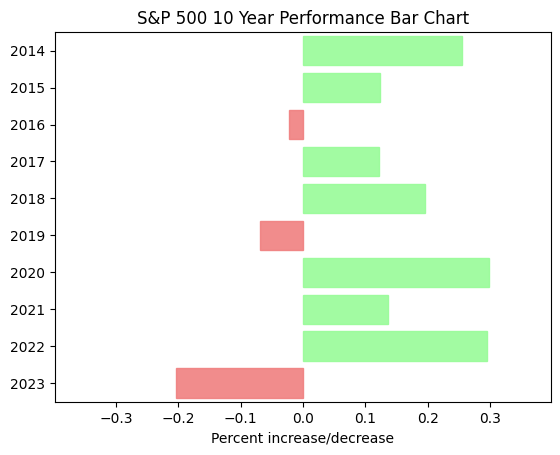

Average Growth: 0.11%


In [8]:
# Ticker for Vanguard 500 Index Fund which mirrors the S&P 500
s_and_p =get_stock_array("voo", 2006, 2023)
plot_stock_bar_graph(s_and_p, "S&P 500 10 Year Performance Bar Chart", save=False)

s_and_p_growth_rate = get_growth_rate(s_and_p)
print(get_growth_rate(s_and_p, print=True))

## Outperforming the S&P 500

While an average of 11% increase each year is very good, the purpose of this reasearch is to highlight if there are other mutual funds which outperform the S&P 500.

Below includes the graphs of various mutual funds found on various websites as well as a graph comparing them to the S&P 500. The goal is to find one with an average growth above that of the S&P 500

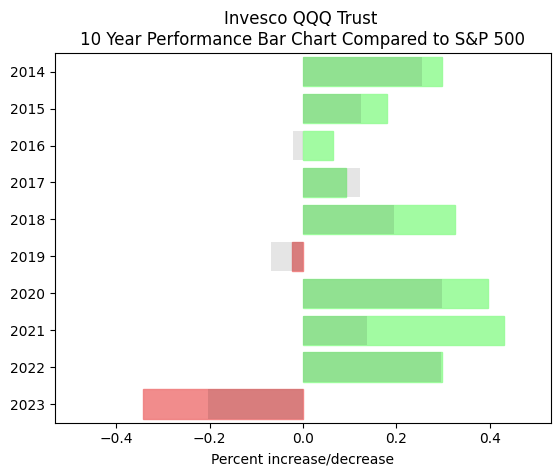

Average Growth: 0.17%


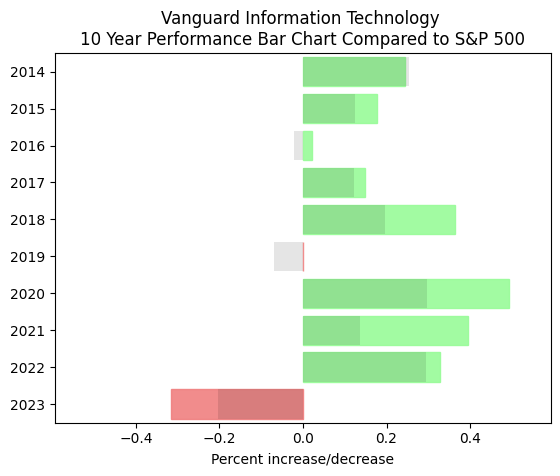

Average Growth: 0.19%


In [9]:
# Has the start/end year for the calculations
# The threshold for what rate is significant enough of annual returns to print
# And the array with the ticker name followed by the printed name

# And will then create a chart compared to the S&P 500 of the best mutual funds
# As well as their growth rate

start_year = 2013
end_year = 2023
print_threshold = s_and_p_growth_rate
index_array = [
    ["FCNTX", "Fidelity Contrafund"],
    ["VGTSX", "Vanguard Total International Stock Index Fund"],
    ["IWO", "iShares Russell 2000 Growth ETF"],
    ["QQQM", "Invesco NASDAQ 100 "],
    ["AGTHX", "American Funds Growth Fund of America"],
    ["QQQ", "Invesco QQQ Trust"],
    ["VYM", "Vanguard High Dividend Yield Index Fund "],
    ["VNQ", "Vanguard Real Estate"],
    ["FNILX", "Fidelity ZERO Large Cap Index"],
    ["FCNTX", "Fidelity Contrafund"],
    ["VGT", "Vanguard Information Technology"],
    ["VTI", "Vanguard Total Stock Market"],
]

outperforming_index = [["VOO", "S&P 500"]]

for index in index_array:
    if not is_empty_ticker(index[0], start_year):
        stock_arr =get_stock_array(index[0], start_year, end_year)
        
        if get_growth_rate(stock_arr) > print_threshold:
            compared_plot_stock_bar_graph(stock_arr, s_and_p, f"{index[1]} \n10 Year Performance Bar Chart Compared to S&P 500")
            print(get_growth_rate(stock_arr, print=True))
            
            outperforming_index.append([index[0], index[1]])

## Results of Outperforming the S&P 500

Out of the 12 funds included, only 2 funds had an average growth that is equal to or better than the S&P 500. Both of the funds that were ranked higher are Technology sector funds meaning that they are significantly less diversified being that they are only in one sector. Upon further analysis, the Investco doesn'st seem like it performed much greater than the S&P 500 where as the Vanguard IT performed significantly higher with a spike around 2020 and is currently growing rapidly. 

Text(0, 0.5, '% Increase from start')

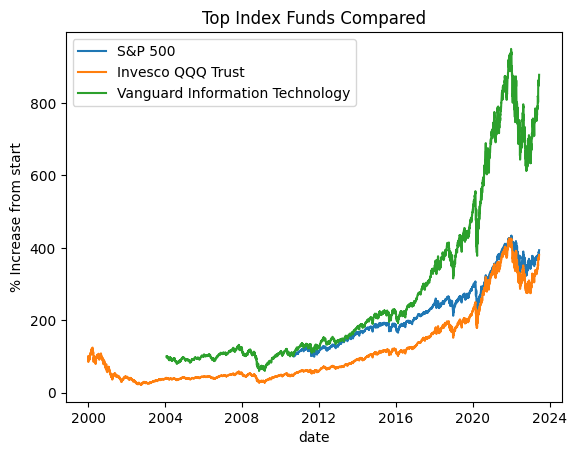

In [10]:
for index in outperforming_index:
    ticker = Ticker(index[0]).history(start="2000-01-01")
    ticker["close"] = ticker["close"] / ticker.iloc[0]["close"] * 100
    
    sns.lineplot(data=ticker, x="date", y="close", label=index[1])
plt.legend()
plt.title("Top Index Funds Compared")
plt.ylabel("% Increase from start")

# plt.savefig('indexFund-fig2.png',bbox_inches='tight', dpi=300, transparent=True)

## Conclusion

The conclusion that I have come to is that the S&P still holds as a very good index fund to invest in. While there are a very small portion that do perform greater than the S&P 500, the only ones I found were limited to the technology sector making them less stable. 

Furthermore, this analysis is only over the recent 20ish and below years which doesn't show the bigger picture. It also only factors in daily closing values and doesn't rate on reliability or include information like dividend yields.

That being said, it does show that there are index funds which outperform the S&P 500 on yearly yields in recent years.